In [39]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd 
import pickle

from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tqdm import tqdm_notebook
from scipy.spatial.distance import cosine, hamming

%matplotlib inline 

### Step 1 Dataset utils and preprocessing

In [35]:
def image_loader(image_path, image_size):
    '''
    Load an image from a disk.
    
    :param image_path: String, path to the image
    :param image_size: tuple, size of an output image Example: image_size=(32, 32)
    '''
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC)
    return image

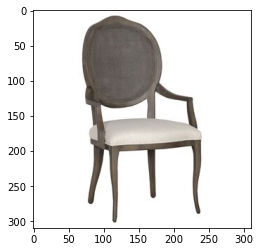

In [40]:
plt.imshow(image.load_img('images/wayfair/dining-chairs/EAOC8629.png'))

In [41]:
image = image_loader('images/wayfair/dining-chairs/EAOC8629.png', (200,200))

In [4]:
# load all images and labels at once
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):
    
    with open(labels_file_path, 'r') as f:
        classes = f.read().split('\n')[:-1]
        
    images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path , image_name)
            images.append(image_loader(image_path, image_size))
            image_paths.append(image_path)
            
            for idx in range(len(classes)):
                if classes[idx] in image_name:
                    labels.append(idx)
        except:
            pass
        
    with open(image_paths_pickle + '.pickle', 'wb') as f:
        pickle.dump(image_paths, f)
        
    assert len(images) == len(labels)
    return np.array(images), np.array(labels)    

## Step2 : utils function

In [6]:
def cosine_distance(training_set_vectors, query_vector, top_n = 10):
    
    distances = []
    
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i], query_vector[0]))
    
    return np.argsort(distances)[:top_n]

In [7]:
def hamming_distance(training_set_vectors, query_vector, top_n = 10):
    
    distances = []
    
    for i in range(len(training_set_vectors)):
        distances.append(hamming(training_set_vectors[i], query_vector[0]))
    
    return np.argsort(distances)[:top_n]


In [8]:
# calculates the accuracy of the model
def sparse_accuracy(true_labels, predicted_labels):
    
    assert len(true_labels) == len(predicted_labels)
    
    correct = 0
    
    for i in range(len(true_labels)):
        
        if np.argmax(predicted_labels[i]) == true_labels[i]:
            correct +=1
            
    return correct/ len(true_labels)

## Step 3 Model utils

In [ ]:
#Use keras.Input instead of placeholders
            make_dict[key] = tf.keras.Input(name=key, shape=(), dtype=tf.dtypes.float32)
        else:

In [29]:
def model_inputs(image_size):
    
    inputs = tf.keras.Input(dtype = tf.dtypes.float32, \
                            shape = (image_size[0], image_size[1], 3),\
                            name = 'images') # 3 for RGB channels
    targets = tf.keras.Input(dtype = tf.dtypes.int32, shape = (), name = 'targets')
    dropout_rate = tf.keras.Input(dtype= tf.float32, name = 'dropout_rate')
    
    return inputs, targets, dropout_rate

In [10]:
def conv_block(inputs, 
               number_of_filters,
               kernel_size,
               strides = (1,1),
               padding = 'SAME',
               activation = tf.nn.relu,
               max_pool = True,
               batch_norm = True):
    '''
    Defines convolutional block layer.
    
    :param inputs: data from a previous layer
    :param number_of_filters: integer, number of conv filters
    :param kernel_size: tuple, size of conv layer kernel
    :param padding: string, type of padding technique: SAME or VALID
    :param activation: tf.object, activation function used on the layer
    :param max_pool: boolean, if true the conv block will use max_pool
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    
    conv_features = layer = tf.layers.conv2d(inputs=inputs, 
                                             filters=number_of_filters, 
                                             kernel_size=kernel_size, 
                                             strides=strides, 
                                             padding=padding, 
                                             activation=activation)
    
    if max_pool:
        layer = tf.layers.max_pooling2d(layer, 
                                        pool_size=(2, 2), 
                                        strides=(2, 2),
                                        padding='SAME')
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, conv_features

In [11]:
def dense_block(inputs, 
                units, 
                activation=tf.nn.relu, 
                dropout_rate=None, 
                batch_norm=True):
    
    '''
    Defines dense block layer.
    
    :param inputs: data from a previous layer
    :param units: integer, number of neurons/units for a dense layer
    :param activation: tf.object, activation function used on the layer
    :param dropout_rate: dropout rate used in this dense block
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    
    dense_features = layer = tf.layers.dense(inputs, 
                                             units=units, 
                                             activation=activation)
    
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer, rate=dropout_rate)
    
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, dense_features

In [12]:
def opt_loss(logits, 
             targets, 
             learning_rate):
    
    '''
    Defines model's optimizer and loss functions.
    
    :param logits: pre-activated model outputs
    :param targets: true labels for each input sample
    :param learning_rate: learning_rate
    '''
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return loss, optimizer

In [30]:
from tensorflow.python.framework import ops
ops.reset_default_graph()



class ImageSearchModel(object):
    
    def __init__(self, 
                 learning_rate, 
                 image_size, 
                 number_of_classes=2):
        
        '''
        Defines CNN model.
        
        :param learning_rate: learning_rate
        :param image_size: tuple, (height, width) of an image
        :param number_of_classes: integer, number of classes in a dataset.
        '''
        
        #tf.reset_default_graph()
        
        #model inputs
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf.layers.batch_normalization(self.inputs)
        
        #conv_1 block
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images, 
                                                        number_of_filters=64, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
 
        #conv_2 block
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1, 
                                                        number_of_filters=128, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #conv_3 block
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2, 
                                                        number_of_filters=256, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #conv_4 block
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3, 
                                                        number_of_filters=512, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #flattening
        flat_layer = tf.layers.flatten(conv_block_4)
        
        #1st dense block
        dense_block_1, dense_1_features = dense_block(inputs=flat_layer, 
                                                       units=128, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #2nd dense block
        dense_block_2, self.dense_2_features = dense_block(inputs=dense_block_1, 
                                                       units=256, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #3rd dense block
        dense_block_3, self.dense_3_features = dense_block(inputs=dense_block_2, 
                                                       units=512, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #4th dense block
        dense_block_4, self.dense_4_features = dense_block(inputs=dense_block_3, 
                                                       units=1024, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #output layer
        logits = tf.layers.dense(inputs=dense_block_4, 
                                 units=number_of_classes, 
                                 activation=None)
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.optimizer = opt_loss(logits=logits, 
                                             targets=self.targets, 
                                             learning_rate=learning_rate)

In [42]:
model = ImageSearchModel(0.001 , (32,32) , 2)

ValueError: Please provide to Input a `shape` or a `tensor` or a `type_spec` argument. Note that `shape` does not include the batch dimension.

## Step 4: Training Loop - training the model

In [33]:
def train(model, 
          epochs,
          drop_rate,
          batch_size, 
          data, 
          save_dir, 
          saver_delta=0.15):
    
    '''
    The core training function, use this function to train a model.
    
    :param model: CNN model
    :param epochs: integer, number of epochs
    :param drop_rate: float, dropout_rate
    :param batch_size: integer, number of samples to put through the model at once
    :param data: tuple, train-test data Example(X_train, y_train, X_test, y_test)
    :param save_dir: string, path to a folder where model checkpoints will be saved
    :param saver_delta: float, used to prevent overfitted model to be saved
    '''
    
    X_train, y_train, X_test, y_test = data
    
    #start session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    #define saver
    saver = tf.train.Saver()
    
    best_test_accuracy = 0.0
    
    #start training loop
    for epoch in range(epochs):
        
        train_accuracy = []
        train_loss = []
        
        for ii in tqdm(range(len(X_train) // batch_size)):
            start_id = ii*batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch, 
                         model.targets:y_batch, 
                         model.dropout_rate:drop_rate}
            
            _, t_loss, preds_t = session.run([model.optimizer, model.loss, model.predictions], feed_dict=feed_dict)
            
            train_accuracy.append(sparse_accuracy(y_batch, preds_t))
            train_loss.append(t_loss)
            
        print("Epoch: {}/{}".format(epoch, epochs),  
              " | Training accuracy: {}".format(np.mean(train_accuracy)), 
              " | Training loss: {}".format(np.mean(train_loss)) )
        
        test_accuracy = []
        
        for ii in tqdm(range(len(X_test) // batch_size)):
            start_id = ii*batch_size
            end_id = start_id + batch_size
            
            X_batch = X_test[start_id:end_id]
            y_batch = y_test[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch, 
                         model.dropout_rate:0.0}
            
            preds_test = session.run(model.predictions, feed_dict=feed_dict)
            test_accuracy.append(sparse_accuracy(y_batch, preds_test))
            
        print("Test accuracy: {}".format(np.mean(test_accuracy)))
        
        #saving the model
        if np.mean(train_accuracy) > np.mean(test_accuracy): #to prevent underfitting
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta: #to prevent overfit
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    saver.save(session, "{}/model_epoch_{}.ckpt".format(save_dir, epoch))
                    
    session.close()

In [34]:
# example
len_x_train = 100
batch_size = 9

for i in range(len_x_train // batch_size):
    start_id = i * batch_size
    end_id = start_id + batch_size
    
    print(start_id, end_id)

0 9
9 18
18 27
27 36
36 45
45 54
54 63
63 72
72 81
81 90
90 99


## Setting Hyperparameters and training the model

In [ ]:
epochs = 20
batch_size = 128
learning_rate = 0.001
dropout_probs = 0.6
image_size = (32, 32)

